## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Rescaling
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import EarlyStopping

## Load Data

In [2]:
dataset=pd.read_csv("train.csv")
#train images
train_images="./train_images/"

## Explore Dataset

In [3]:
dataset.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

In [4]:
dataset.shape


(10407, 4)

In [5]:
dataset['label'].value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

In [6]:
dataset['variety'].unique().tolist()

['ADT45',
 'IR20',
 'KarnatakaPonni',
 'Onthanel',
 'Ponni',
 'Surya',
 'Zonal',
 'AndraPonni',
 'AtchayaPonni',
 'RR']

In [7]:
dataset['age'].describe()

count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64

## EDA

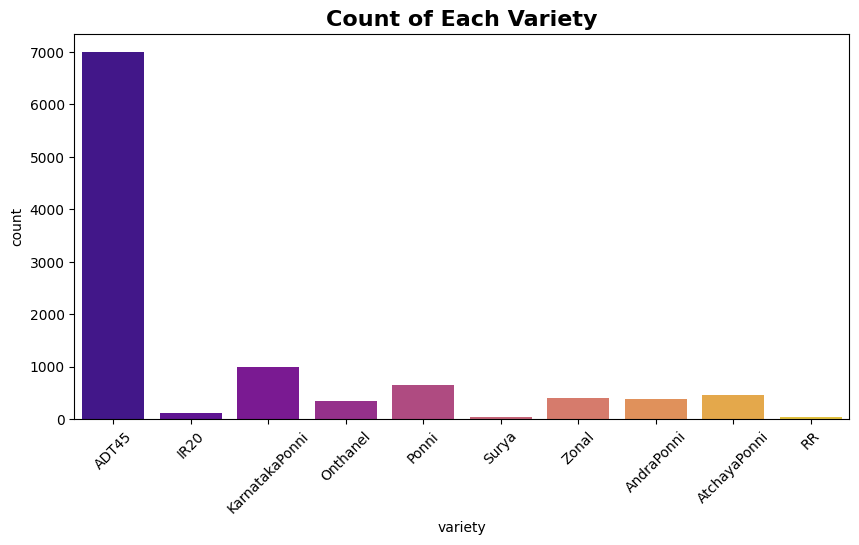

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x='variety', data=dataset, palette='plasma' , hue='variety') 
plt.xticks(rotation=45)
plt.title('Count of Each Variety', fontsize=16, weight='bold')
plt.show()

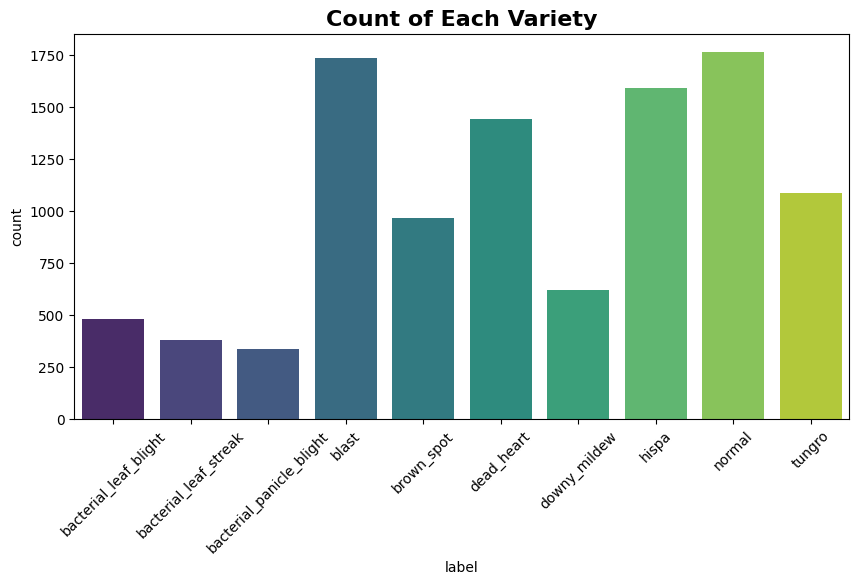

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=dataset, palette='viridis' , hue='label') 
plt.xticks(rotation=45)
plt.title('Count of Each Variety', fontsize=16, weight='bold')
plt.show()

## IMAGES OF RICE PLANTS

In [10]:
normal = dataset[dataset['label'] =='normal']
normal = normal[normal['variety'] =='ADT45']
five_normals = normal.image_id[:5].values
five_normals.tolist()

['100007.jpg', '100025.jpg', '100135.jpg', '100165.jpg', '100171.jpg']

In [11]:
dead = dataset[dataset['label'] =='dead_heart']
dead = dead[dead['variety'] =='ADT45']
five_deads= dead.image_id[:5].values
five_deads.tolist()

['101165.jpg', '102750.jpg', '108367.jpg', '109900.jpg', '100222.jpg']

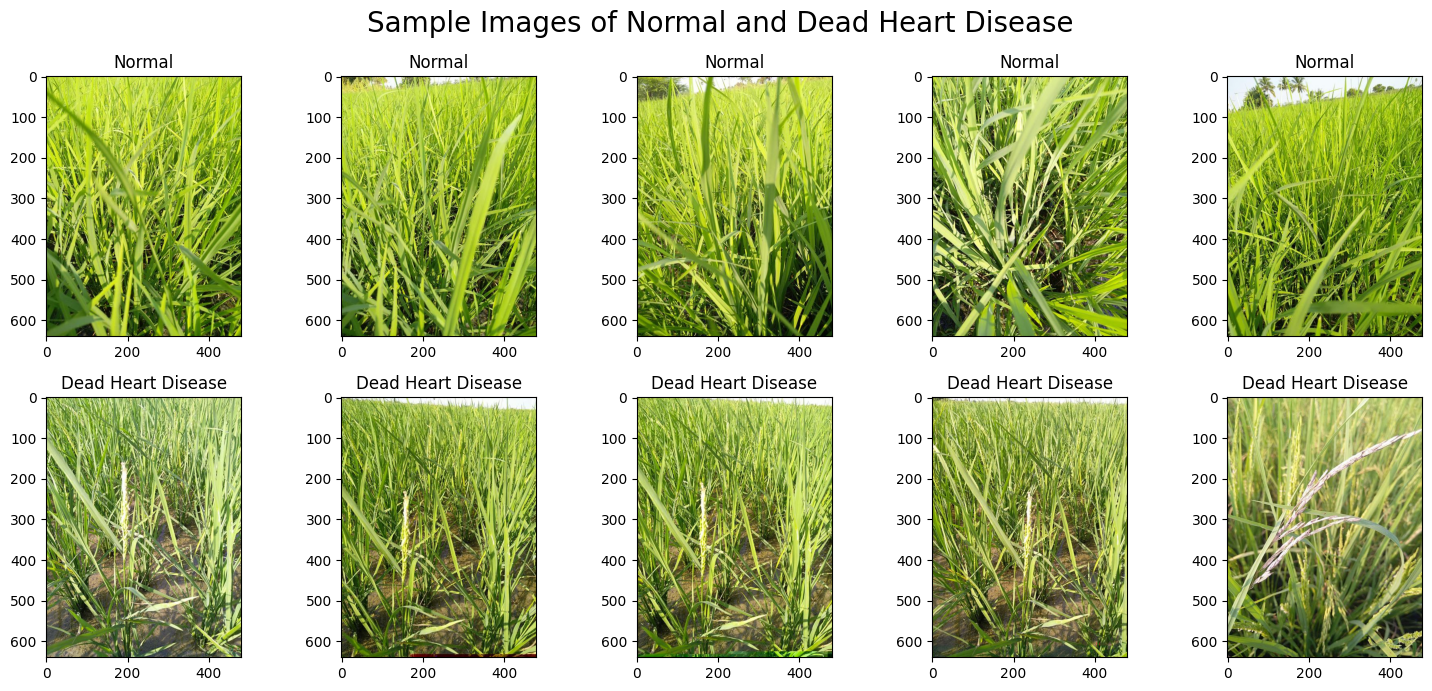

In [12]:
plt.figure(figsize=(15, 7))
plt.suptitle("Sample Images of Normal and Dead Heart Disease", fontsize=20)
for i, image_loc in enumerate(np.concatenate((five_normals, five_deads))):
    plt.subplot(2, 5, i + 1) 

    if i < 5:
        image=plt.imread(train_images +"normal/"+ image_loc)
        plt.title("Normal")
    else:
        image = plt.imread(train_images + "dead_heart/" + image_loc)
        plt.title("Dead Heart Disease")
    
    plt.imshow(image)
plt.tight_layout()
plt.show()

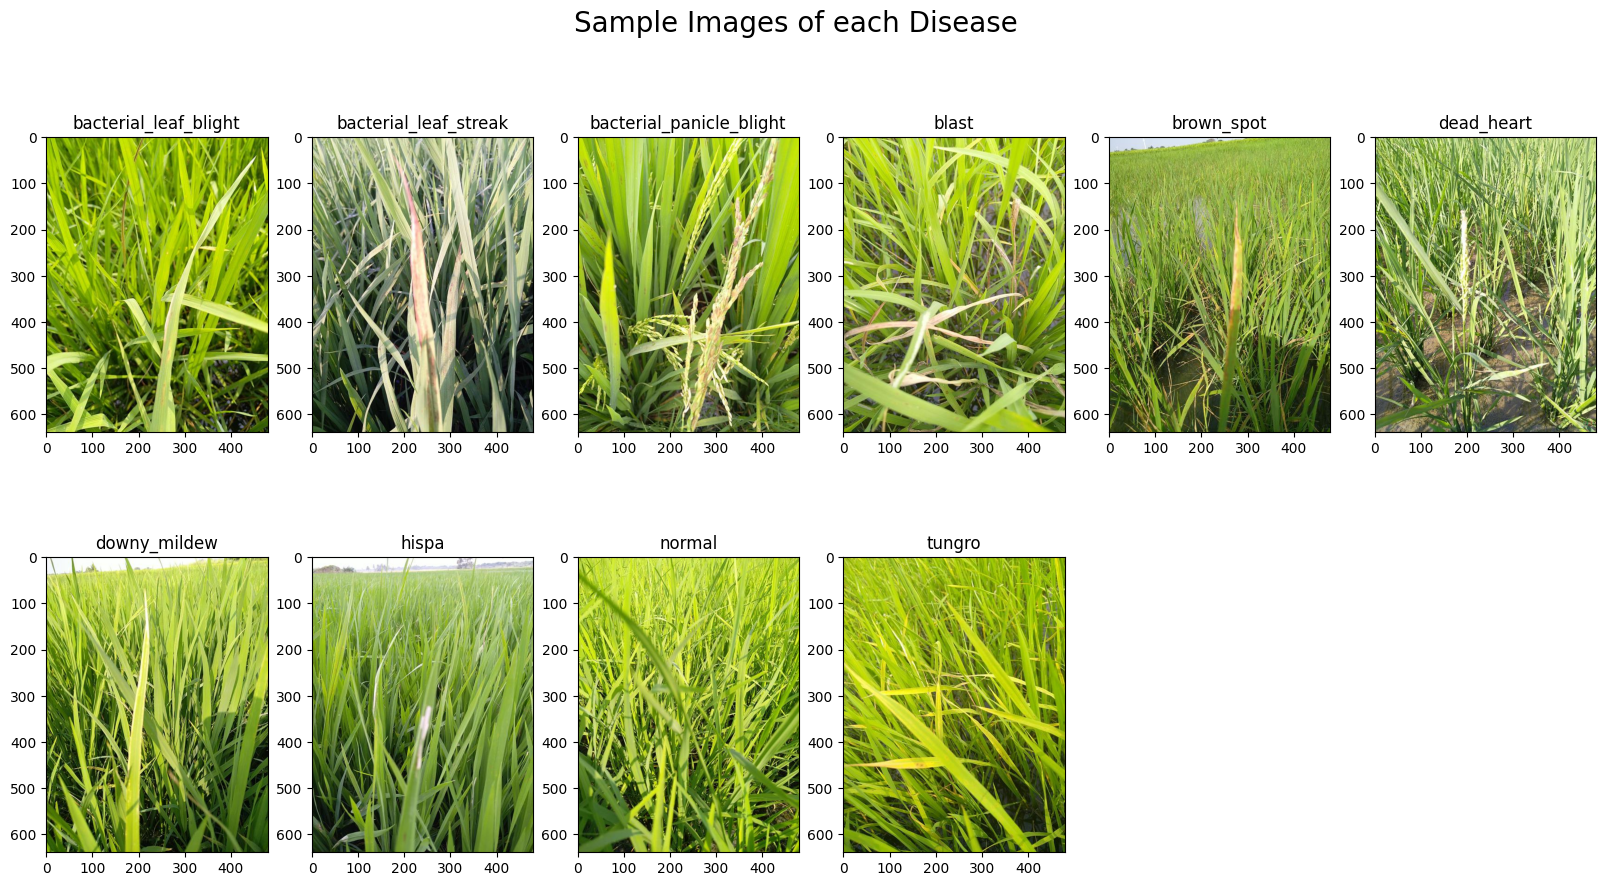

In [13]:
#unique images  of every disease
diseases = dataset['label'].unique()
images = [train_images + disease + '/' + dataset[dataset['label'] == disease].iloc[0]['image_id'] for disease in diseases]
columns = 6
plt.figure(figsize=(20, 10))
plt.suptitle("Sample Images of each Disease", fontsize=20)
for i, image_loc in enumerate(images):
    plt.subplot(len(images) // columns + 1, columns, i + 1)
    image = plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

## Label Encoding

In [32]:
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])
dataset['variety'] = label_encoder.fit_transform(dataset['variety'])
labels = dataset['label'].value_counts()
print(labels)
num_labels=len(labels)
num_labels

label
8    1764
3    1738
7    1594
5    1442
9    1088
4     965
6     620
0     479
1     380
2     337
Name: count, dtype: int64


10

In [16]:
# parameters
batch_size = 16
img_height = 128
img_width = 128

## Training and Validation Data

In [17]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_images,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    shuffle=True
)


Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [18]:

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_images,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    shuffle=True
)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [19]:
normalize_image=tf.keras.layers.Rescaling(1./255)



In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)


## Model Building

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,308,522 (12.62 MB)

 Trainable params: 3,308,522 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compiling

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_ds, validation_data=validation_ds, epochs=10, callbacks=[early_stop])

Epoch 1/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 243s 463ms/step - accuracy: 0.2214 - loss: 2.1229 - val_accuracy: 0.4363 - val_loss: 1.6593
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 224s 430ms/step - accuracy: 0.4923 - loss: 1.5003 - val_accuracy: 0.6112 - val_loss: 1.1768
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 228s 437ms/step - accuracy: 0.6977 - loss: 0.9218 - val_accuracy: 0.7251 - val_loss: 0.9879
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 235s 451ms/step - accuracy: 0.8220 - loss: 0.5647 - val_accuracy: 0.7468 - val_loss: 0.9344
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 234s 449ms/step - accuracy: 0.8852 - loss: 0.3457 - val_accuracy: 0.7198 - val_loss: 1.3166
Epoch 6/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 240s 461ms/step - accuracy: 0.9264 - loss: 0.2267 - val_accuracy: 0.7559 - val_loss: 1.1212
Epoch 7/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 239s 459ms/step - accuracy: 0.9405 - loss: 0.1760 - val_accuracy: 0.7045 - val_loss: 1.6719


In [24]:
loss , accuracy = model.evaluate(validation_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6979 - loss: 1.7505
Loss:  1.6719133853912354
Accuracy:  0.7044690251350403


## Loss and Accuracy Plotting

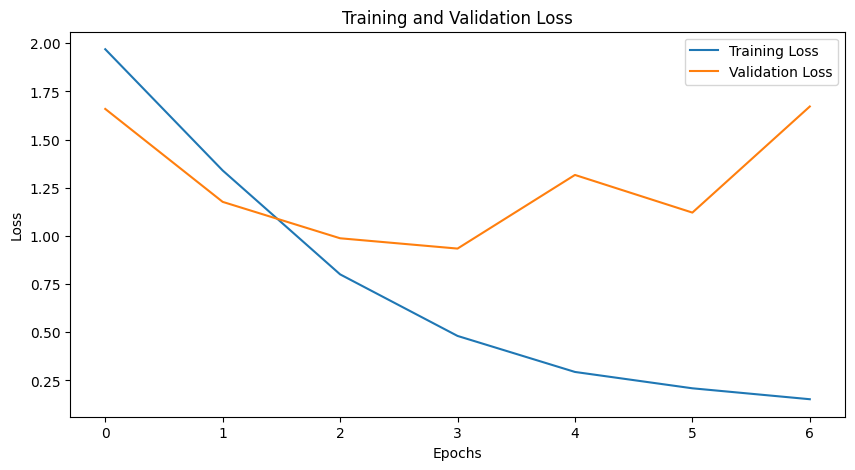

In [25]:
# plot the Training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

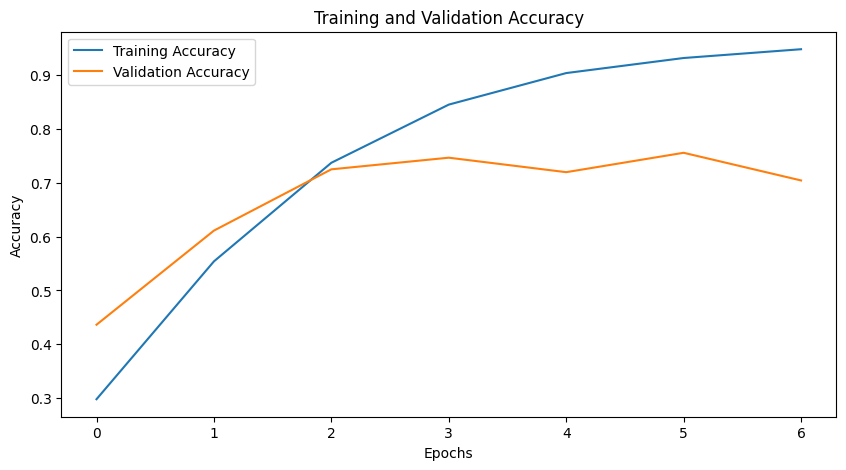

In [26]:
# plot the Training  and validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()